In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import scikitplot as skplt

from IPython.display import Image
from itertools import cycle
from mpl_toolkits.mplot3d import Axes3D
from scipy import interp
from scipy.stats import randint as sp_randint
from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, accuracy_score, confusion_matrix, classification_report, make_scorer, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import export_graphviz
from sklearn.utils import resample

# Classification (with labels given by the clustering)

## Decision tree

In [2]:
customer_profile = pd.read_csv('datasets/customer_indicators.csv', index_col=0)
customer_clustering = pd.read_csv('datasets/clustering_labels.csv', index_col=0)
customer_clustering = customer_profile[['CustomerID', 'Delta','Median', 'RFrequency']].merge(customer_clustering[['CustomerID', 'Label']], on='CustomerID')
 #del customer_profile
customer_clustering

,CustomerID,Delta,Median,RFrequency,Label
0,12347,366,584.910,0.019126,High
1,12348,283,298.500,0.014134,Medium
2,12350,1,294.400,1.000000,Low
3,12352,261,226.250,0.026820,Medium
4,12353,1,89.000,1.000000,Low
...,...,...,...,...,...
3855,18280,1,180.600,1.000000,Low
3856,18281,1,80.820,1.000000,Low
3857,18282,119,89.025,0.016807,Medium
3858,18283,334,113.500,0.047904,Medium


In [3]:
df_majority = customer_clustering[customer_clustering.Label == 'Medium']
df_minority = customer_clustering[customer_clustering.Label == 'High']
df_middle   = customer_clustering[customer_clustering.Label == 'Low']

customer_clustering.Label.value_counts()

Medium    1698
Low       1250
High       912
Name: Label, dtype: int64

In [4]:
'''
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority))

# Upsample minority class
df_middle_upsampled = resample(df_middle, 
                               replace=True,     # sample with replacement
                               n_samples=len(df_majority))

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled, df_middle_upsampled])
 
# Display new class counts
customer_clustering = df_upsampled
df_upsampled.Label.value_counts()'''

'\n# Upsample minority class\ndf_minority_upsampled = resample(df_minority, \n                                 replace=True,     # sample with replacement\n                                 n_samples=len(df_majority))\n\n# Upsample minority class\ndf_middle_upsampled = resample(df_middle, \n                               replace=True,     # sample with replacement\n                               n_samples=len(df_majority))\n\n# Combine majority class with upsampled minority class\ndf_upsampled = pd.concat([df_majority, df_minority_upsampled, df_middle_upsampled])\n \n# Display new class counts\ncustomer_clustering = df_upsampled\ndf_upsampled.Label.value_counts()'

In [5]:

# Upsample minority class
df_majority_undersampled = resample(df_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_minority))

# Upsample minority class
df_middle_undersampled = resample(df_middle, 
                               replace=True,     # sample with replacement
                               n_samples=len(df_minority))

# Combine majority class with upsampled minority class
df_undersampled = pd.concat([df_minority, df_majority_undersampled, df_middle_undersampled])
 
# Display new class counts
customer_clustering = df_undersampled
df_undersampled.Label.value_counts()

Low       912
High      912
Medium    912
Name: Label, dtype: int64

In [6]:
# Function to discretize the variables
# Input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        mapping = {'High': 0, 'Medium': 1, 'Low': 2}

        # Add a new colum with the number representation of the variable
        dataset[variable + '_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [7]:
variables = ['Label']

# Discretize data, in this case only Label
customer_clustering = discretize_data(customer_clustering, variables)

# Drop the categorical variables since we don't need them anymore 
customer_clustering = customer_clustering[['Delta','Median','Label_num']]

label = customer_clustering.pop('Label_num')

scaler = StandardScaler()
customer_clustering = scaler.fit_transform(customer_clustering.values)

train_set, test_set, train_label, test_label = train_test_split(
                                                 customer_clustering, label, stratify=label, test_size=0.3)

## Expected prediction

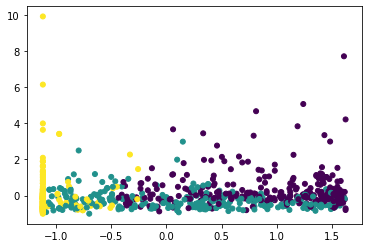

In [8]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_label.values, s=25)
plt.show()

## Decision Tree

In [9]:
# Decision tree

param_dist = {"max_depth": [2,3,5,6,7,10,12],
              "min_samples_split": sp_randint(20, 30),
              "min_samples_leaf": sp_randint(5, 30),
              "criterion": ["entropy", "gini"],
              "splitter": ["best"]
              }

n_iter_search = 50

dec_t = tree.DecisionTreeClassifier()

grid_search = RandomizedSearchCV(dec_t, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

In [10]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 20, 'min_samples_split': 22, 'splitter': 'best'}
Mean and std of this setting  0.712793733681462 0.018089303473304223


In [11]:
# Decision tree best setting parameters

dec_t = tree.DecisionTreeClassifier(criterion='entropy', splitter='best',
                                  max_depth=6,
                                  min_samples_split=28, min_samples_leaf=27).fit(train_set, train_label)

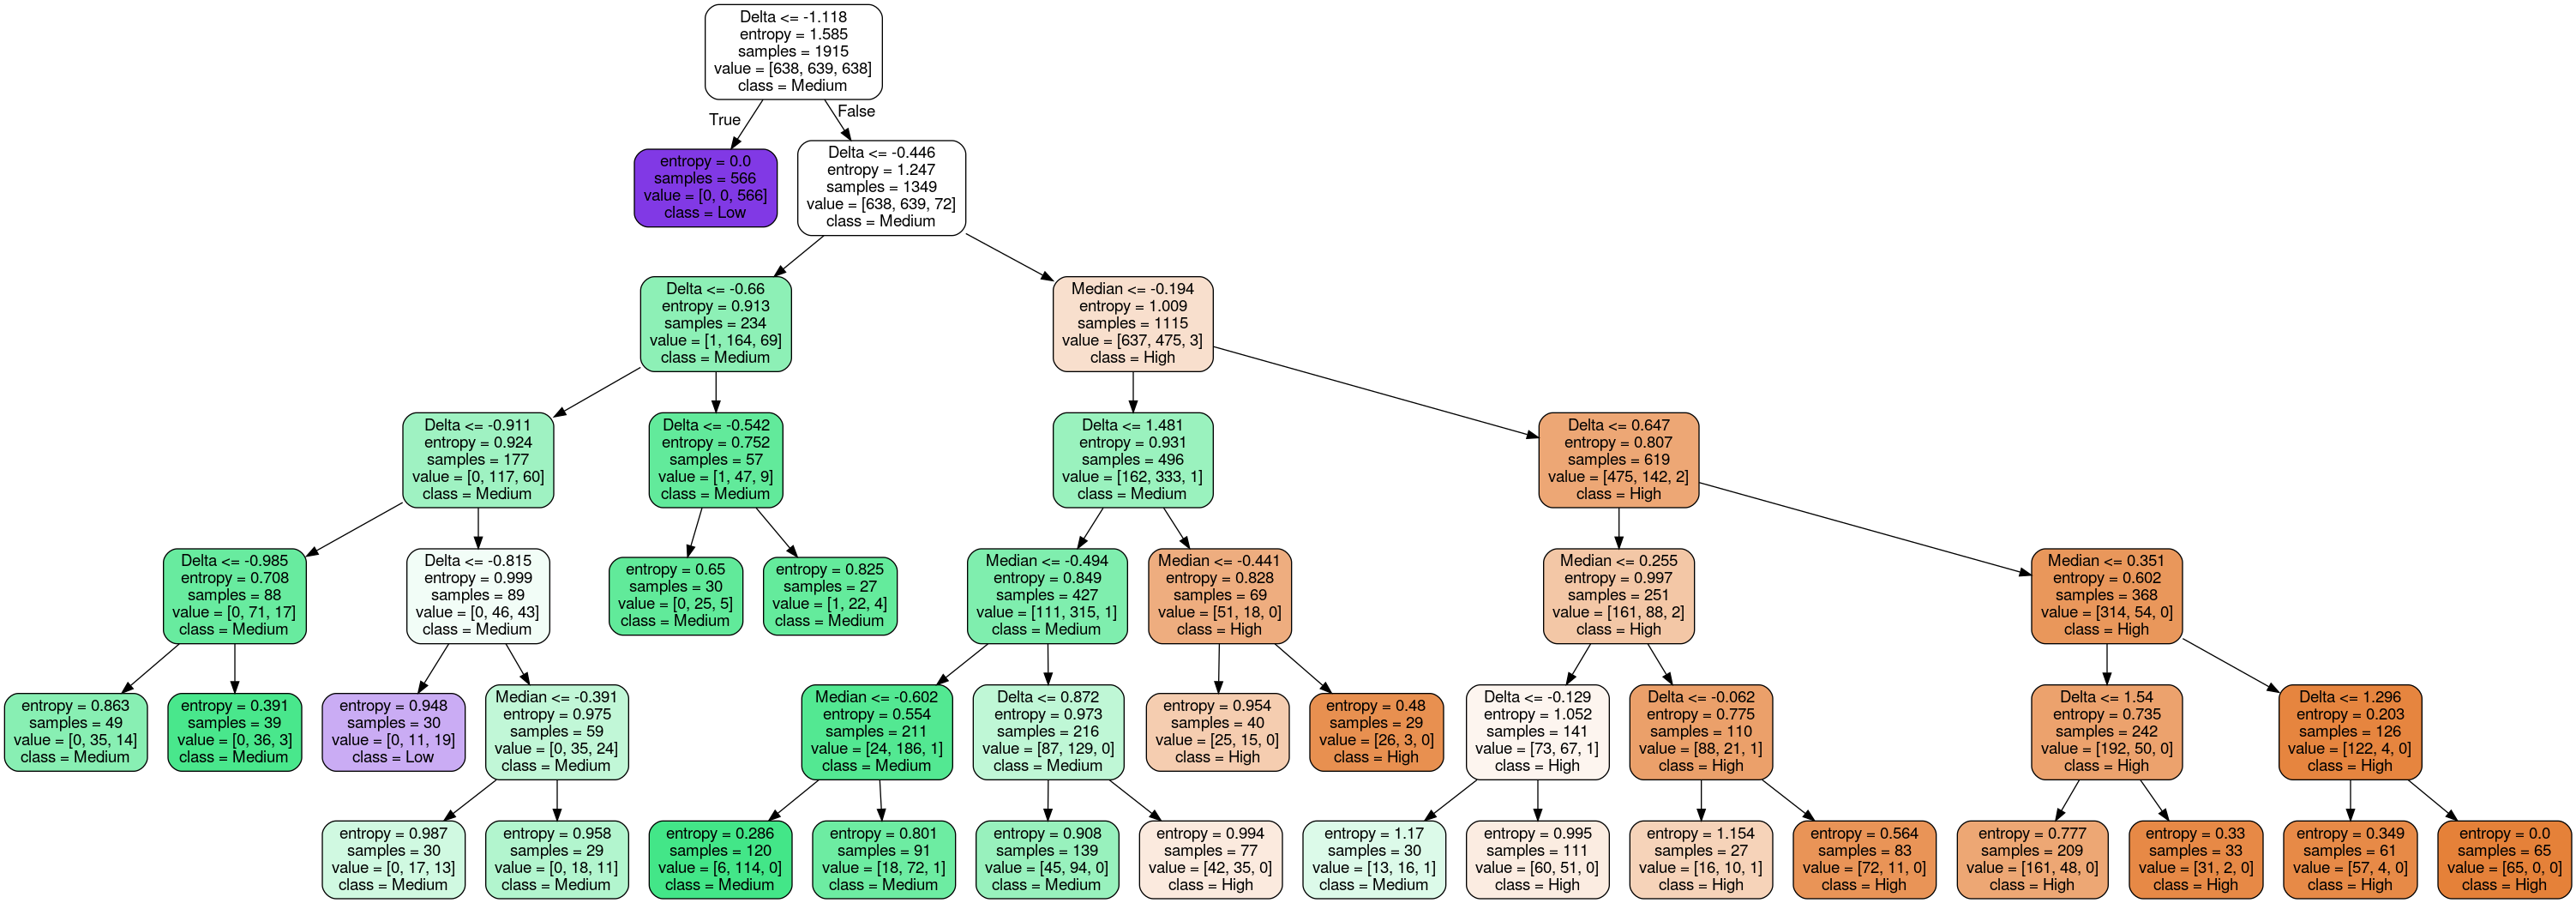

In [12]:
# Show decision tree

dot_data = tree.export_graphviz(dec_t, out_file=None,
                         feature_names=['Delta', 'Median'],
                         class_names=['High', 'Medium', 'Low'],
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [13]:
def predict(model, train_set, test_set):
    train_pred = model.predict(train_set)
    test_pred = model.predict(test_set)
    return train_pred, test_pred

In [14]:
# Predict phase

train_pred_dt, test_pred_dt = predict(dec_t, train_set, test_set)

### Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix

In [15]:
def print_scores(train_label, train_pred, test_label, test_pred, target_names_):
    print('Accuracy train set:', metrics.accuracy_score(train_label, train_pred))
    print('Accuracy test set: ', metrics.accuracy_score(test_label, test_pred))
    print()
    print('F1 score train set:', metrics.f1_score(train_label, train_pred, average='weighted'))
    print('F1 score test set: ', metrics.f1_score(test_label, test_pred, average='weighted'))
    print('Train:')
    print(classification_report(train_label, train_pred, target_names=target_names_))
    print('-' * 53)
    print('Test:')
    print(classification_report(test_label, test_pred, target_names=target_names_))

In [16]:
print_scores(train_label, train_pred_dt, test_label, test_pred_dt, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8297650130548303
Accuracy test set:  0.8246041412911084

F1 score train set: 0.8302314620336559
F1 score test set:  0.8232618771864028
Train:
              precision    recall  f1-score   support

        High       0.76      0.87      0.81       638
      Medium       0.77      0.70      0.73       639
         Low       0.98      0.92      0.95       638

    accuracy                           0.83      1915
   macro avg       0.84      0.83      0.83      1915
weighted avg       0.84      0.83      0.83      1915

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.78      0.88      0.82       274
      Medium       0.77      0.69      0.73       273
         Low       0.93      0.91      0.92       274

    accuracy                           0.82       821
   macro avg       0.83      0.82      0.82       821
weighted avg       0.83      0.82      0.82       821



In [17]:
# Compute confusion matrix.

print('Train:')
print(confusion_matrix(train_label, train_pred_dt))
print('-' * 18)
print('Test:')
print(confusion_matrix(test_label, test_pred_dt))

Train:
[[555  83   0]
 [179 449  11]
 [  1  52 585]]
------------------
Test:
[[240  34   0]
 [ 66 188  19]
 [  2  23 249]]


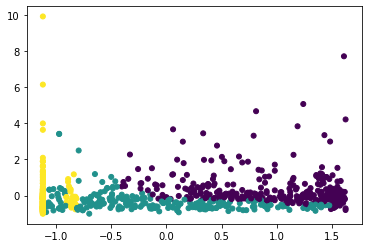

In [18]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_dt, s=25)
plt.show()

## SVM

In [19]:
# Binarize the output
test_label_binarized = label_binarize(test_label, classes=[0, 1, 2])
train_label_binarized = label_binarize(train_label, classes=[0, 1, 2])

svm = SVC(kernel='rbf', C=0.75).fit(train_set, train_label)
svm_binarize = OneVsRestClassifier(svm).fit(train_set, train_label_binarized)

In [20]:
# Predictions

train_pred_svm_binarized, test_pred_svm_binarized = predict(svm_binarize, train_set, test_set)
train_pred_svm, test_pred_svm = predict(svm, train_set, test_set)

In [21]:
# Compute the performance of the model

print_scores(train_label, train_pred_svm, test_label, test_pred_svm, ['High', 'Medium', 'Low'])

Accuracy train set: 0.7963446475195822
Accuracy test set:  0.8124238733252132

F1 score train set: 0.792951136988274
F1 score test set:  0.8104068745752421
Train:
              precision    recall  f1-score   support

        High       0.77      0.83      0.80       638
      Medium       0.72      0.63      0.68       639
         Low       0.88      0.93      0.91       638

    accuracy                           0.80      1915
   macro avg       0.79      0.80      0.79      1915
weighted avg       0.79      0.80      0.79      1915

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.80      0.83      0.81       274
      Medium       0.74      0.68      0.71       273
         Low       0.89      0.93      0.91       274

    accuracy                           0.81       821
   macro avg       0.81      0.81      0.81       821
weighted avg       0.81      0.81      0.81       821



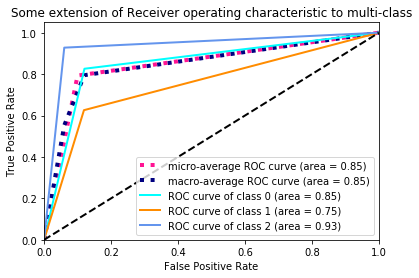

In [22]:
n_classes = 3
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(train_label_binarized[:, i], train_pred_svm_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(train_label_binarized.ravel(), train_pred_svm_binarized.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

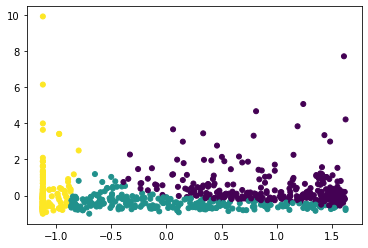

In [23]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_svm, s=25)
plt.show()

## KNN

In [24]:
knn = KNeighborsClassifier(n_neighbors=8, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

In [25]:
train_pred_knn, test_pred_knn = predict(knn, train_set, test_set)

In [26]:
print_scores(train_label, train_pred_knn, test_label, test_pred_knn, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8438642297650131
Accuracy test set:  0.8294762484774665

F1 score train set: 0.843220053554892
F1 score test set:  0.8288944253526601
Train:
              precision    recall  f1-score   support

        High       0.78      0.88      0.83       638
      Medium       0.80      0.72      0.76       639
         Low       0.96      0.93      0.95       638

    accuracy                           0.84      1915
   macro avg       0.85      0.84      0.84      1915
weighted avg       0.85      0.84      0.84      1915

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.79      0.85      0.82       274
      Medium       0.77      0.72      0.74       273
         Low       0.93      0.92      0.93       274

    accuracy                           0.83       821
   macro avg       0.83      0.83      0.83       821
weighted avg       0.83      0.83      0.83       821



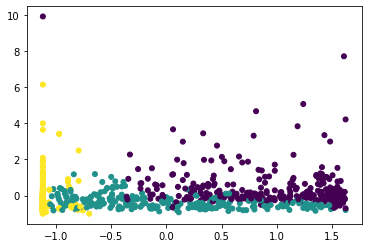

In [27]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_knn, s=25)
plt.show()

## Classification with Random Forest

In [28]:
# Define and fit a random forest.

param_dist = {"max_depth": [2, 3, 5, 6, 7, 10, 12, None],
              "max_features": sp_randint(1,len(train_set[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight": ['balanced', None, {0: 0.25, 1: 0.50, 2:0.25}]}

n_iter_search = 50

rf = RandomForestClassifier(n_estimators=30)
grid_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

In [29]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': False, 'class_weight': {0: 0.25, 1: 0.5, 2: 0.25}, 'criterion': 'gini', 'max_depth': 3, 'max_features': 1, 'min_samples_leaf': 32, 'min_samples_split': 42}
Mean and std of this setting  0.7926892950391645 0.017049428425393743


In [30]:
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='entropy',
                             max_features=2,
                             class_weight= 'balanced',
                             max_depth=5, 
                             min_samples_split=20,
                             min_samples_leaf=18,
                             bootstrap=False).fit(train_set, train_label)

In [31]:
train_pred_rf, test_pred_rf = predict(rf, train_set, test_set)

In [32]:
print_scores(train_label, train_pred_rf, test_label, test_pred_rf, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8245430809399478
Accuracy test set:  0.8148599269183922

F1 score train set: 0.8261226125378873
F1 score test set:  0.8147594245081311
Train:
              precision    recall  f1-score   support

        High       0.76      0.82      0.79       638
      Medium       0.74      0.73      0.74       639
         Low       0.98      0.92      0.95       638

    accuracy                           0.82      1915
   macro avg       0.83      0.82      0.83      1915
weighted avg       0.83      0.82      0.83      1915

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.78      0.83      0.80       274
      Medium       0.73      0.71      0.72       273
         Low       0.93      0.91      0.92       274

    accuracy                           0.81       821
   macro avg       0.82      0.81      0.81       821
weighted avg       0.82      0.81      0.81       821



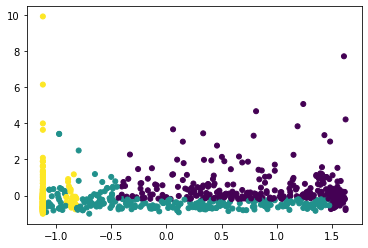

In [33]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_rf, s=25)
plt.show()

## Neural networks

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.python.keras.utils.np_utils import to_categorical

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(1, len(customer_clustering[0]))))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
train_label_nn = to_categorical(train_label, 3)
test_label_nn = to_categorical(test_label, 3)

In [36]:
history = model.fit(train_set, train_label_nn,
                    epochs=40,
                    batch_size=256,
                    validation_split=0.3)

Epoch 1/40
6/6 [==============================] - 4s 410ms/step - loss: 1.0991 - accuracy: 0.3592 - val_loss: 1.0593 - val_accuracy: 0.5009
Epoch 2/40
6/6 [==============================] - 0s 16ms/step - loss: 1.0640 - accuracy: 0.4821 - val_loss: 1.0188 - val_accuracy: 0.6887
Epoch 3/40
6/6 [==============================] - 0s 15ms/step - loss: 1.0169 - accuracy: 0.5990 - val_loss: 0.9742 - val_accuracy: 0.6765
Epoch 4/40
6/6 [==============================] - 0s 14ms/step - loss: 0.9888 - accuracy: 0.6286 - val_loss: 0.9252 - val_accuracy: 0.6522
Epoch 5/40
6/6 [==============================] - 0s 15ms/step - loss: 0.9268 - accuracy: 0.6617 - val_loss: 0.8732 - val_accuracy: 0.6504
Epoch 6/40
6/6 [==============================] - 0s 15ms/step - loss: 0.8826 - accuracy: 0.6618 - val_loss: 0.8226 - val_accuracy: 0.6470
Epoch 7/40
6/6 [==============================] - 0s 16ms/step - loss: 0.8459 - accuracy: 0.6436 - val_loss: 0.7761 - val_accuracy: 0.6470
Epoch 8/40
6/6 [==========

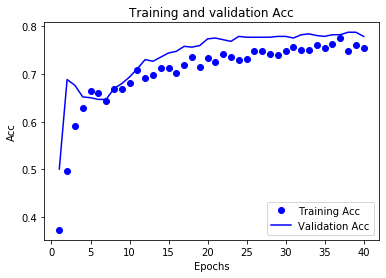

In [37]:
lw = 2
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [38]:
train_pred_nn = np.argmax(model.predict(train_set), axis=-1)
test_pred_nn = np.argmax(model.predict(test_set), axis=-1)

In [39]:
print_scores(train_label, train_pred_nn, test_label, test_pred_nn, ['High', 'Medium', 'Low'])

Accuracy train set: 0.7801566579634465
Accuracy test set:  0.7746650426309378

F1 score train set: 0.7696457285406063
F1 score test set:  0.7638788587294909
Train:
              precision    recall  f1-score   support

        High       0.75      0.83      0.79       638
      Medium       0.73      0.54      0.62       639
         Low       0.84      0.97      0.90       638

    accuracy                           0.78      1915
   macro avg       0.77      0.78      0.77      1915
weighted avg       0.77      0.78      0.77      1915

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.77      0.85      0.81       274
      Medium       0.72      0.53      0.61       273
         Low       0.81      0.95      0.87       274

    accuracy                           0.77       821
   macro avg       0.77      0.77      0.76       821
weighted avg       0.77      0.77      0.76       821



## Classification with Naive Bayes

In [40]:
gnb = GaussianNB().fit(train_set, train_label)

train_pred_gnb, test_pred_gnb = predict(gnb, train_set, test_set)

In [41]:
print_scores(train_label, train_pred_gnb, test_label, test_pred_gnb, ['High', 'Medium', 'Low'])

Accuracy train set: 0.7462140992167102
Accuracy test set:  0.7344701583434835

F1 score train set: 0.740400864848651
F1 score test set:  0.7285906012954184
Train:
              precision    recall  f1-score   support

        High       0.69      0.75      0.72       638
      Medium       0.64      0.54      0.59       639
         Low       0.88      0.94      0.91       638

    accuracy                           0.75      1915
   macro avg       0.74      0.75      0.74      1915
weighted avg       0.74      0.75      0.74      1915

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.70      0.73      0.72       274
      Medium       0.62      0.53      0.57       273
         Low       0.86      0.93      0.90       274

    accuracy                           0.73       821
   macro avg       0.73      0.73      0.73       821
weighted avg       0.73      0.73      0.73       821



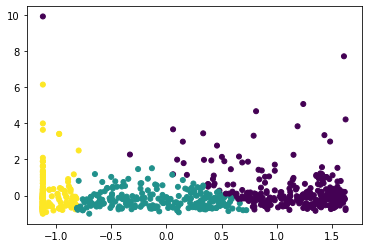

In [42]:

plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_gnb, s=25)
